In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!python -m spacy download el # greek lang
!python -m spacy download el_core_news_sm
!pip install greek-stemmer
!pip install lime

     |████████████████████████████████| 11.4MB 1.6MB/s 
  Created wheel for el-core-news-sm: filename=el_core_news_sm-2.2.5-cp36-none-any.whl size=11422788 sha256=678b9a072786bb9df6cb5c226242c9fcc4b0ca101e235d9abc0f3c95ea79c738
  Stored in directory: /tmp/pip-ephem-wheel-cache-zqbg489b/wheels/70/a1/c5/6690d6b524d87e287a8070cf957f834fb1b1665b9ede11348b
Successfully built el-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/el_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/el
You can now load the model via spacy.load('el')
✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')
  Created wheel for greek-stemmer: filename=greek_stemmer-0.1.1-cp36-none-any.whl size=6738 sha256=b8cdc5d36ef8ae1a87d6f7a3de3c1c4022b44c22ee5d987f83a14336c7c1b3b6
  Stored in directory: /root/.cache/pip/wheels/b9/e5/39/735c9926a0

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
from spacy.lang.el.stop_words import STOP_WORDS
import itertools   
from spacy.lang.el import Greek
import string
import el_core_news_sm
import imblearn
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy import stats
from greek_stemmer import GreekStemmer
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
revs_preprocessed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/preprocessed_Greek.csv") 
revs_preprocessed.sample(5)
revs_preprocessed = revs_preprocessed.dropna()
revs_preprocessed['review'] = revs_preprocessed['review'].astype(str)
revs_preprocessed = revs_preprocessed.sample(frac=1)
revs_preprocessed

,review,approved
70556,ευγενικος καθαρος ελαφροχερης,1
120820,μπραβο γιατρο πολυ καλη επεξηγηματικη,1
100727,σοβαρος αξιοπιστος αξιοπρεπης γιατρος,1
7414,γνωστης αντικειμενου κ κανει νιωσεις ανετα κ κ...,1
22100,εμπειρος ευγενικος συνεπης αρτια καταρτηση,1
...,...,...
73753,επεξηγηματικος σχολαστικος ειλικρινης ξεκαθαρο...,1
96096,πρωτη επισκεψη πολυ θετικη,1
41458,μεθοδικος επαγγελματισμο ενσυναισθηση,1
89792,πολυ ωραιο περιβαλλον παιδια πολυ επεξηγηματικ...,1


In [ ]:
revs_preprocessed.approved.value_counts()

1    120360
0      7052
Name: approved, dtype: int64

If we use stemming

In [ ]:
stemmer = GreekStemmer()

def stemming(text):
    text = [stemmer.stem(word.upper()) for word in text.split()]

    return " ".join(text)

#revs_preprocessed["review"] = revs_preprocessed["review"].map(stemming)
#revs_preprocessed["review"] = revs_preprocessed.review.str.lower()

## Split Dataset

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# splitting in train-validation-test sets in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# sss: stratified shuffle split

# We will use this object to split the raw dataset in Train - Test in a stratified manner.

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)

test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [ ]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [ ]:
reviews = revs_preprocessed.review
approval = revs_preprocessed.approved

In [ ]:
# splitting in train-val and test

X_train_val, X_test, y_train_val, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(reviews, approval):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = reviews.iloc[train_index], reviews.iloc[test_index]
    y_train_val, y_test = approval.iloc[train_index], approval.iloc[test_index]

TRAIN-VAL: [ 82540  40139  39998  91772  31563 126709  71879 125848  44624  91703] TEST: [ 48280  94719 114242  40191 101511  36848  29030   7137  21234  44228]
TRAIN-VAL: [73244 58001 59362 27161 94823 10526 67299 17171 84445 20031] TEST: [ 32739  97774  13925  30133  69275  88494  17763  68949  83196 116453]
TRAIN-VAL: [125386  86088  78676 110340  76756  81467 116079  40909  37380      6] TEST: [118364   7766 118670  36074  46827  25791  20618  55362  63840  69706]
TRAIN-VAL: [ 48974 121050  70095 107734  84503 104067 125514 112439  51872  53572] TEST: [68100 60797 11782 11735 31939 47220 81680 28950 15795 58395]
TRAIN-VAL: [ 16658  52472  91390   8946  82650  51483  35226 109653  31254  78774] TEST: [ 4783 20518 66330 64235 49167  1440  4618 70134 73246  5866]


In [ ]:
X_train_val.head()

8788          συνεπης σχολαστικοτατη προτεινα ανεπιφυλακτα
12622    ασχοληθηκε περιπτωση δεν κοιταξε απλα ξεφορτωθ...
41931                                   εξυπηρετικη φιλικη
46838    σωστος επαγγελματιας γνωση αντικειμενου ενδιαφ...
21687                 παρα πολυ καλος συστηνω ανεπιφυλακτα
Name: review, dtype: object

In [ ]:
X_train_val.shape, X_train_val.dropna().shape

((108300,), (108300,))

In [ ]:
y_train_val.shape, y_train_val.dropna().shape

((108300,), (108300,))

In [ ]:
# We reset the indexes for bot the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [ ]:
# splitting the train-val dataset into train and validation dataset

X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

TRAIN: [ 81938  30988  34406  10973    636  59632  66476  95354  92178 102431] VALID: [ 4783 20518 66330 64235 49167  1440  4618 70134 73246  5866]
TRAIN: [ 30014 103652 107119  27713  19994   4881  44402  66722  24989  57429] VALID: [ 4783 20518 66330 64235 49167  1440  4618 70134 73246  5866]
TRAIN: [ 52654  36708  80607   8442 108034 107195  25843  18606  61439  61519] VALID: [ 4783 20518 66330 64235 49167  1440  4618 70134 73246  5866]
TRAIN: [19772 47443 70624 27828 95105 74593 97998 32485 34874 47525] VALID: [ 4783 20518 66330 64235 49167  1440  4618 70134 73246  5866]
TRAIN: [13985 25928 41869 53268 15336 63983 39082 57268 32744 22757] VALID: [ 4783 20518 66330 64235 49167  1440  4618 70134 73246  5866]


In [ ]:
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train_val shape: (108300,)
y_train_val shape: (108300,)

X_train shape: (86640,)
y_train shape: (86640,)

X_val shape: (21660,)
y_val shape: (21660,)

X_test shape: (19112,)
y_test shape: (19112,)


### Labels One-hot Encoding (not included)

In [ ]:
# Encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [ ]:
#y_enc.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# At first we run fit_transform on the Training data
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
y_train_final =  np.asarray(y_train)
y_train_final

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
y_val_final = np.asarray(y_val)
y_test_final = np.asarray(y_test)

In [ ]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [ ]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (86640, 2)
y_val shape: (21660, 2)
y_test shape: (19112, 2)


In [ ]:
#temp.sum(axis=0).head(10)

In [ ]:
#temp.sum(axis=1).sample(10)

In [ ]:
# deleting the variable (just for demonstration purposes)
#del temp

do we need the target variable one-hot encoded?

## Tokenization

In [ ]:
# Load Greek tokenizer, tagger, parser, NER and word vectors
parser = Greek()

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

## Handling Text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# A pandas Series is also an iterable. So we can handle it like a List.
# Concatenating all reviews into one text.
corpora = " ".join(reviews)

print(corpora[:1000])

ευγενικος καθαρος ελαφροχερης μπραβο γιατρο πολυ καλη επεξηγηματικη σοβαρος αξιοπιστος αξιοπρεπης γιατρος γνωστης αντικειμενου κ κανει νιωσεις ανετα κ καλα χερια εμπειρος ευγενικος συνεπης αρτια καταρτηση εμπνεει εμπιστοσυνη ανθρωπια δειχνει απολυτο ενδιαφερον περιπτωση ασθενους εξαιρετικη επιστημονας αρκετα αναλυτικη κατα εξεταση προθυμη λυσει οποια απορια μπορει υπηρξε διαθετει πολυ συγχρονο ιατρειο αρκετα προσεγμενο ενεπνευσε εμπιστοσυνη φυσικα συστηνω ανεπιφυλακτα γιατρος εξαιρετικος αριστος γνωστηστου αντικειμενου πολυ ευγενικος υπομονετικος συνεπης εμπειρος γιατρος εκανε πληρη ελεγχο μυτη λαιμο καιπολυ καλο καθαρισμο αυτιων κερι προτεινα ανεπιφυλακτα ποιοτικη εξεταση πολυ καλη συμπεριφορα προσεγγισηθα μπορουσε μουσικη αναμονη ειχε χαμηλοτερη ενταση όσον αφορα επιστημονικο κομματι σωστος ολα διαγνωση θεραπεια χρονος αποκαταστασης πρεπει πει αυξανω τυυροιδ αντισωματα ειπε καλα αργοτερα 2η γνωμη αλλο ενδροκρινολογο εξετασεις πρεπει στειλει ταχυτητα ρεμουτολογικο επειδη εχεται συναφη

In [ ]:
top_words = Counter(corpora.split()).most_common()
top_words[:20]

[('πολυ', 59352),
 ('γιατρος', 31458),
 ('ανεπιφυλακτα', 15773),
 ('καλος', 14319),
 ('δεν', 13315),
 ('εμπιστοσυνη', 12472),
 ('εξαιρετικος', 11748),
 ('προβλημα', 10447),
 ('ραντεβου', 10392),
 ('καλη', 9445),
 ('ανθρωπος', 8797),
 ('ολα', 8356),
 ('συστηνω', 8107),
 ('περιπτωση', 7216),
 ('εξαιρετικη', 7194),
 ('κ', 6784),
 ('ευγενικος', 6478),
 ('επαγγελματιας', 6386),
 ('προσιτος', 6261),
 ('γιατρο', 6098)]

In [ ]:
# Total Number of Words to use for vectorization. 
# The vectorizer will keep the K most common tokens (words-characters)
max_words = 3000

'''stop_words = [
    'αν', 'απ', 'απο', 'ας', 'για', 'γιατι', 'εγω', 'ειναι', 'ενα',
    'εσυ', 'ετσι', 'εχει', 'η', 'ηταν', 'θα', 'και', 'και', 'κι', 'κ', 'μα', 'μας',
    'με', 'μες', 'μη', 'μην', 'μια', 'μου', 'μου', 'μου,', 'μ’', 'ν', 'να', 'ο',
    'οι', 'ομως', 'οπως', 'οταν', 'οτι', 'πια', 'πιο', 'που', 'πως', 'πως', 'σ',
    'σαν', 'σε', 'σου', 'σου', 'σου', 'στα', 'στη', 'στην', 'στις', 'στο', 'στον',
    'τ', 'τα', 'τη', 'την', 'της', 'τι', 'τις', 'το', 'τον', 'του', 'τους', 'των'
]'''

punctuations = string.punctuation
punctuations = punctuations.replace('@', '') # remove @ for emails

### Bag of Words Approach (BoW)


In [ ]:
# This vectorizer will give the number of appearances of each word
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=True, # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7fa5943860d0>,
                vocabulary=None)

Fitting the CountVectorizer **ONLY ON THE TRAINING DATASET**

In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow = counter_vectorizer.fit_transform(X_train)

In [ ]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow = counter_vectorizer.transform(X_val)
X_test_enc_bow = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow.shape))

X_train encoded shape: (86640, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
X_train_enc_bow[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

### Tf-idf vectorizer Approach

In [ ]:
# This vectorizer will give the number of appearances of each word
tfidf_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    #binary=False, # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7fa5943860d0>,
                vocabulary=None)

In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_tfidf = tfidf_vectorizer.transform(X_val)
X_test_enc_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_tfidf.shape))
print('X_val encoded shape: {}'.format(X_val_enc_tfidf.shape))
print('X_test encoded shape: {}'.format(X_test_enc_tfidf.shape))

X_train encoded shape: (86640, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
X_train_enc_tfidf[0].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

Vectorized Representation

In [ ]:
X_counts = X_train_enc_bow
X_tfidf = X_train_enc_tfidf
y = y_train

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="Not Approved")
        green_patch = mpatches.Patch(color="blue", label="Approved")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})


### Comparison

Visualization of vectorized text represantation in order to choose the best one

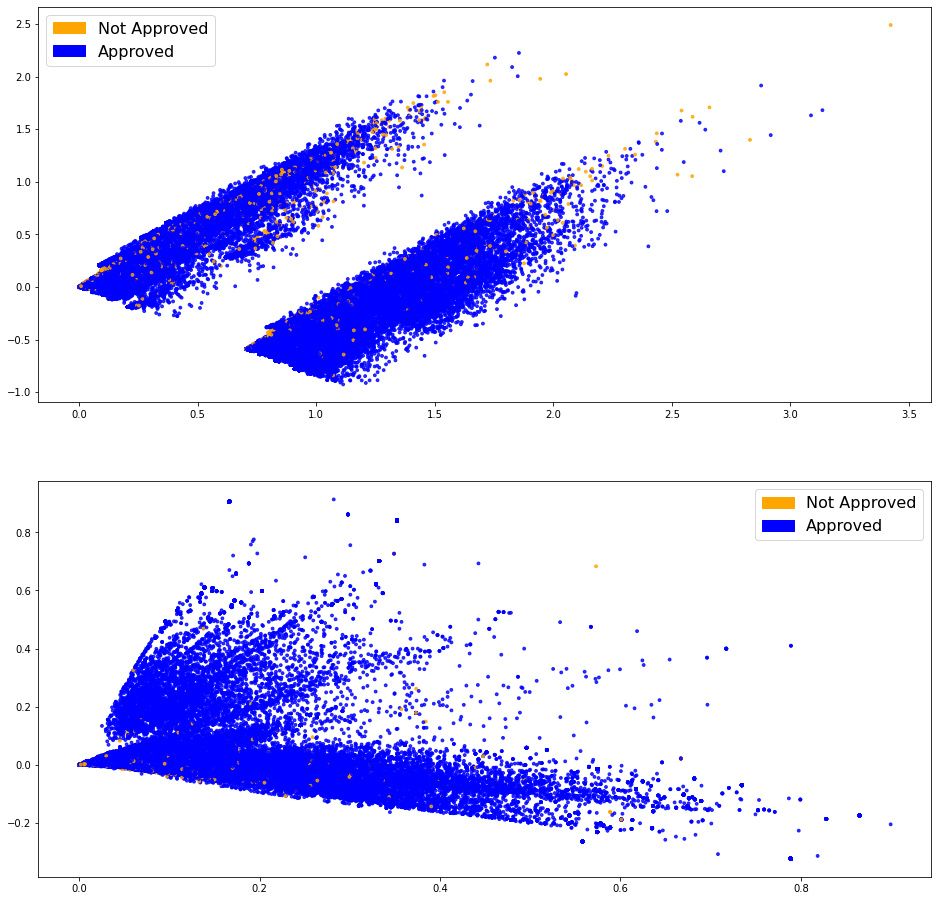

In [ ]:
plt.figure(1, figsize=(16, 16))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)

# Modeling

## Feed-Forward model

### With Imbalanced dataset

In [ ]:
# !pip install pydot
# !pip install graphviz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [ ]:
# Some parameters that we will use:

# Number of Classes for the Y labels
nb_classes = len(y_train.value_counts())

print('Number of Classes: {}'.format(nb_classes))

# Number of Epochs that we will train our Feed Forward Network
nb_epoch = 20

# The batch_size of the data that  will be fed to the Model when training
batch_size = 32 

# Dropout Rate of the Dropout Layer (how many neurons to shutdown each time)
dropout_rate = 0.4

Number of Classes: 2


Model Setup

In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model = Sequential()

# add a dense layer (MLP)
model.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model.add(Dense(512))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model.add(Dense(1)) # if we want to change the one-hot, set dense 1

# use a softmax activation on 2nd MLP's outputs
model.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1

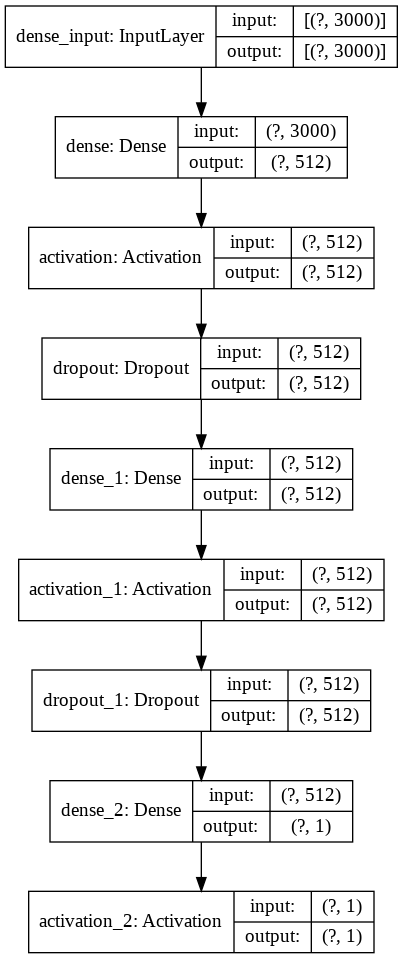

In [ ]:
plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

In [ ]:
X_train_enc_bow

<86640x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 700166 stored elements in Compressed Sparse Row format>

In [ ]:
y_train.shape

(86640,)

In [ ]:
X_val_enc_bow

<21660x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 175855 stored elements in Compressed Sparse Row format>

In [ ]:
y_val.shape

(21660,)

#### Fitting (training) our Feed Forward Network Model

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         

In [ ]:
# We train (fit our data to) our model
history = model.fit(
    x=X_train_enc_bow.todense(),           # features (as dense inputs)
    y=y_train,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    callbacks=early_stop,
    validation_data=(       
    X_val_enc_bow.todense(),               # the validation split that we did before
    y_val)
)

Epoch 1/20
2708/2708 - 41s - loss: 0.1091 - binary_accuracy: 0.9620 - val_loss: 0.0954 - val_binary_accuracy: 0.9647
Epoch 2/20
2708/2708 - 40s - loss: 0.0733 - binary_accuracy: 0.9735 - val_loss: 0.0949 - val_binary_accuracy: 0.9655
Epoch 3/20
2708/2708 - 40s - loss: 0.0484 - binary_accuracy: 0.9822 - val_loss: 0.1252 - val_binary_accuracy: 0.9670
Epoch 4/20
2708/2708 - 40s - loss: 0.0352 - binary_accuracy: 0.9872 - val_loss: 0.1172 - val_binary_accuracy: 0.9668
Epoch 5/20
2708/2708 - 40s - loss: 0.0289 - binary_accuracy: 0.9888 - val_loss: 0.1546 - val_binary_accuracy: 0.9675
Epoch 6/20
2708/2708 - 40s - loss: 0.0269 - binary_accuracy: 0.9896 - val_loss: 0.1434 - val_binary_accuracy: 0.9667
Epoch 7/20
2708/2708 - 40s - loss: 0.0241 - binary_accuracy: 0.9905 - val_loss: 0.1730 - val_binary_accuracy: 0.9666
Epoch 00007: early stopping


In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

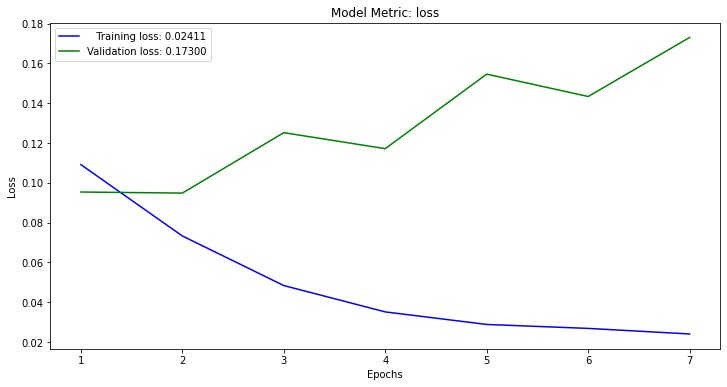

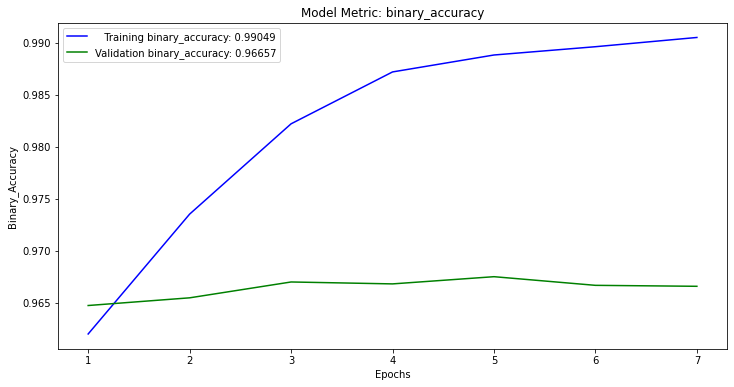

In [ ]:
plot_keras_history(history)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model.evaluate(
    X_test_enc_bow.todense(),    # features
    y_test,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

598/598 - 3s - loss: 0.1660 - binary_accuracy: 0.9672


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.16599918901920319

Test accuracy: 96.725 %


#### Model Prediction 

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict(X_test_enc_bow)
y_test_pred_probs

array([[0.99989814],
       [1.        ],
       [0.99948394],
       ...,
       [0.9996598 ],
       [0.999989  ],
       [0.9998924 ]], dtype=float32)

In [ ]:
y_test_preds = tf.greater(y_test_pred_probs, .5)

In [ ]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

# y_test_preds = model.predict_classes(X_test_enc)

#y_test_preds = np.argmax(model.predict(X_test_enc_bow), axis=-1)

#y_test_preds

In [ ]:
'''# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)'''

'# custom prediction function \ndef get_one_hot_predictions(pred_probs):\n    """\n    """\n    max_probs = np.max(pred_probs, axis=1)\n    \n    # reshaping to (len_of_predicts, 1)\n    max_probs = max_probs.reshape(max_probs.shape[0], 1)\n\n    return np.equal(pred_probs, max_probs).astype(float)'

In [ ]:
#y_test_pred = get_one_hot_predictions(y_test_pred_probs)
#y_test_pred

# check that each line has only one 1. 
# y_test_pred.sum(axis=1)

In [ ]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
#y_test_pred_approval = y_enc.inverse_transform(y_test_pred).flatten()
#y_test_pred_approval[:20]

In [ ]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_preds)
conf_mat

array([[  696,   362],
       [  264, 17790]])

In [ ]:
# a bit prettier
#pd.DataFrame(conf_mat,
#             columns = ["0","1"],
#             index=y_enc.categories_)

In [ ]:
revs_preprocessed.approved.unique()

array([1, 0])

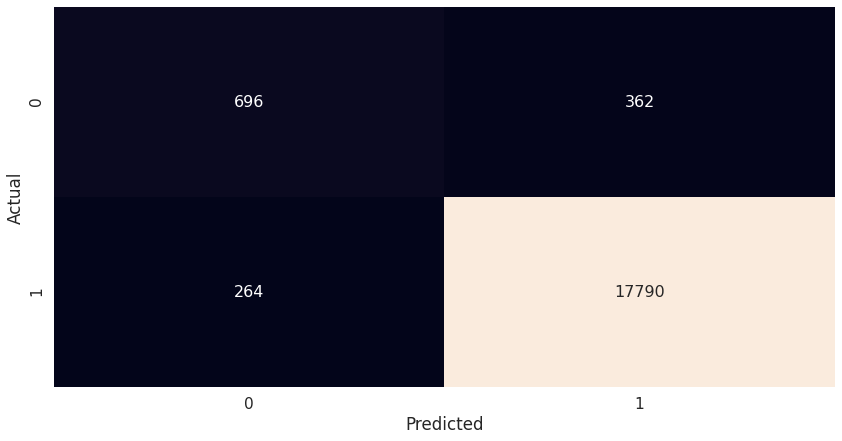

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_preds))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1058
           1       0.98      0.99      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.85      0.82      0.84     19112
weighted avg       0.97      0.97      0.97     19112



In [ ]:
def Approval(prob):
  if prob >= 0.5:
    return 1
  else:
    return 0

In [ ]:
# Predicting a single review

input_rev = """
ο γιατρος ηταν απαραδεκτος
"""

# vectorizing Song with Count Vectorizer
rev_vect = counter_vectorizer.transform([input_rev])

print(rev_vect.shape, end='\n\n')

rev_pred = model.predict(rev_vect)

print('Probabilities', end='\n\n')
print(rev_pred, end='\n\n')

#rev_pred_hot = get_one_hot_predictions(rev_pred)

#print('Probabilities One Hot Vector', end='\n\n')
#print(rev_pred_hot, end='\n\n')

print('Approval Prediction:', end='\n\n')
print(Approval(rev_pred))

(1, 3000)

Probabilities

[[0.01607656]]

Approval Prediction:

0


### Oversampling

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

#num_words = len(counter)

#max_length = 100 # mean is 800
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
not_appr_upsampled = resample(not_approved,
                          replace=True, # sample with replacement
                          n_samples=len(approved)//4, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([approved, not_appr_upsampled])

# check new class counts
print(upsampled.approved.value_counts())
upsampled = upsampled.sample(frac=1)

1    81845
0    20461
Name: approved, dtype: int64


In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow_up = counter_vectorizer.fit_transform(upsampled.review)

# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow_up = counter_vectorizer.transform(X_val)
X_test_enc_bow_up = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow_up.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow_up.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow_up.shape))

X_train encoded shape: (102306, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
#y_train_enc = y_enc.fit_transform(upsampled.approved.values.reshape(-1, 1))
#y_train_enc

In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model_over = Sequential()

# add a dense layer (MLP)
model_over.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model_over.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model_over.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model_over.add(Dense(512))

# use a relu activation on MLP's outputs
model_over.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model_over.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model_over.add(Dense(1)) # if we want to change the one-hot, set dense 1

# use a sigmoid activation
model_over.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model_over.summary())

Building model...

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1536512   
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None,

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model_over.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

#### Fitting (training) our Feed Forward Network Model

In [ ]:
# We train (fit our data to) our model
history_over = model_over.fit(
    x=X_train_enc_bow_up.todense(),           # features (as dense inputs)
    y=upsampled.approved,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    callbacks=early_stop,
    validation_data=(       
    X_val_enc_bow_up.todense(),               # the validation split that we did before
    y_val)
)

Epoch 1/20
3198/3198 - 56s - loss: 0.1510 - binary_accuracy: 0.9478 - val_loss: 0.1181 - val_binary_accuracy: 0.9636
Epoch 2/20
3198/3198 - 55s - loss: 0.0696 - binary_accuracy: 0.9768 - val_loss: 0.1245 - val_binary_accuracy: 0.9636
Epoch 3/20
3198/3198 - 56s - loss: 0.0471 - binary_accuracy: 0.9839 - val_loss: 0.1700 - val_binary_accuracy: 0.9632
Epoch 4/20
3198/3198 - 58s - loss: 0.0416 - binary_accuracy: 0.9861 - val_loss: 0.1676 - val_binary_accuracy: 0.9653
Epoch 5/20
3198/3198 - 56s - loss: 0.0387 - binary_accuracy: 0.9869 - val_loss: 0.1877 - val_binary_accuracy: 0.9657
Epoch 6/20
3198/3198 - 61s - loss: 0.0358 - binary_accuracy: 0.9873 - val_loss: 0.2167 - val_binary_accuracy: 0.9651
Epoch 00006: early stopping


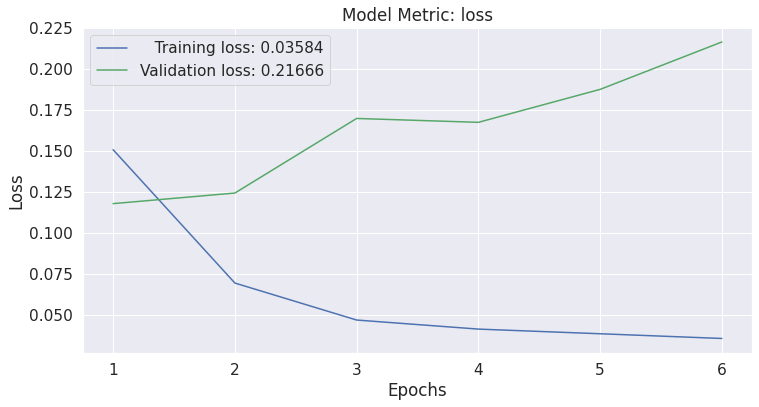

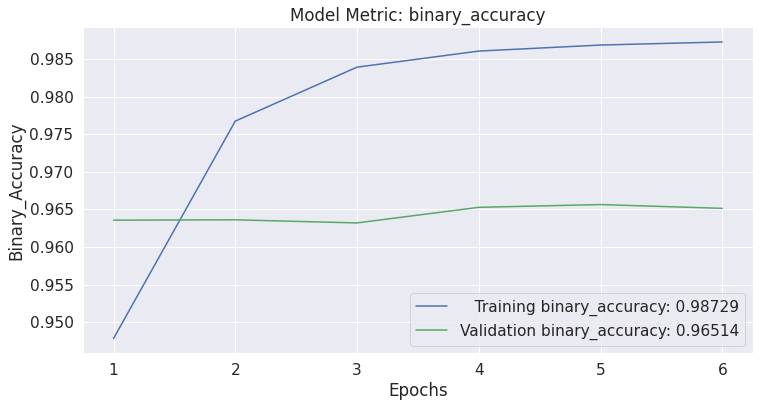

In [ ]:
plot_keras_history(history_over)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model_over.evaluate(
    X_val_enc_bow_up.todense(),    # features
    y_val,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

677/677 - 5s - loss: 0.2167 - binary_accuracy: 0.9651


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.21665582060813904

Test accuracy: 96.514 %


#### Model Prediction

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model_over.predict(X_test_enc_bow_up)
y_test_pred_probs

array([[0.9999982 ],
       [1.        ],
       [0.99913096],
       ...,
       [0.9997964 ],
       [0.9999969 ],
       [0.99982554]], dtype=float32)

In [ ]:
y_test_preds = tf.greater(y_test_pred_probs, .5)

In [ ]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

# y_test_preds = model.predict_classes(X_test_enc)

#y_test_preds = np.argmax(model.predict(X_test_enc_bow), axis=-1)

#y_test_preds[:50]

In [ ]:
'''# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)'''

'# custom prediction function \ndef get_one_hot_predictions(pred_probs):\n    """\n    """\n    max_probs = np.max(pred_probs, axis=1)\n    \n    # reshaping to (len_of_predicts, 1)\n    max_probs = max_probs.reshape(max_probs.shape[0], 1)\n\n    return np.equal(pred_probs, max_probs).astype(float)'

In [ ]:
#y_test_pred = get_one_hot_predictions(y_test_pred_probs)
#y_test_pred

# check that each line has only one 1. 
# y_test_pred.sum(axis=1)

In [ ]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
#y_test_pred_approval = y_enc.inverse_transform(y_test_pred).flatten()
#y_test_pred_approval[:20]

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_preds)
conf_mat

array([[  709,   349],
       [  287, 17767]])

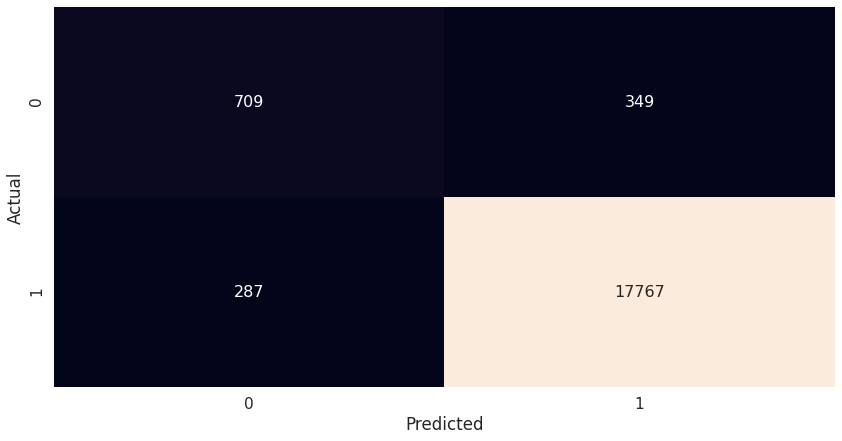

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_preds))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      1058
           1       0.98      0.98      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.85      0.83      0.84     19112
weighted avg       0.97      0.97      0.97     19112



### Undersampling

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
appr_downsampled = resample(approved,
                          replace=True, # sample with replacement
                          n_samples=25000, # match number in majority class
                          random_state=27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_approved, appr_downsampled])

# check new class counts
print(downsampled.approved.value_counts())
downsampled = downsampled.sample(frac=1) #shuffle

1    25000
0     4795
Name: approved, dtype: int64


In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow_down = counter_vectorizer.fit_transform(downsampled.review)

# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow_down = counter_vectorizer.transform(X_val)
X_test_enc_bow_down = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow_down.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow_down.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow_down.shape))

X_train encoded shape: (29795, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model_under = Sequential()

# add a dense layer (MLP)
model_under.add(Dense(256, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model_under.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model_under.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model_under.add(Dense(512))

# use a relu activation on MLP's outputs
model_under.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model_under.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model_under.add(Dense(1)) # if we want to change the one-hot, set dense 1

# use a sigmoid activation
model_under.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model_under.summary())

Building model...

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               768256    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None,

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model_under.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

#### Fitting (training) our Feed Forward Network Model

In [ ]:
# We train (fit our data to) our model
history_under = model_under.fit(
    x=X_train_enc_bow_down.todense(),           # features (as dense inputs)
    y=downsampled.approved,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    callbacks=early_stop,
    validation_data=(       
    X_val_enc_bow_down.todense(),               # the validation split that we did before
    y_val)
)

Epoch 1/20
932/932 - 14s - loss: 0.2036 - binary_accuracy: 0.9290 - val_loss: 0.1291 - val_binary_accuracy: 0.9530
Epoch 2/20
932/932 - 13s - loss: 0.1300 - binary_accuracy: 0.9575 - val_loss: 0.1464 - val_binary_accuracy: 0.9518
Epoch 3/20
932/932 - 14s - loss: 0.0931 - binary_accuracy: 0.9706 - val_loss: 0.1343 - val_binary_accuracy: 0.9582
Epoch 4/20
932/932 - 14s - loss: 0.0685 - binary_accuracy: 0.9782 - val_loss: 0.1896 - val_binary_accuracy: 0.9512
Epoch 5/20
932/932 - 14s - loss: 0.0549 - binary_accuracy: 0.9823 - val_loss: 0.1866 - val_binary_accuracy: 0.9560
Epoch 6/20
932/932 - 14s - loss: 0.0471 - binary_accuracy: 0.9852 - val_loss: 0.2033 - val_binary_accuracy: 0.9553
Epoch 00006: early stopping


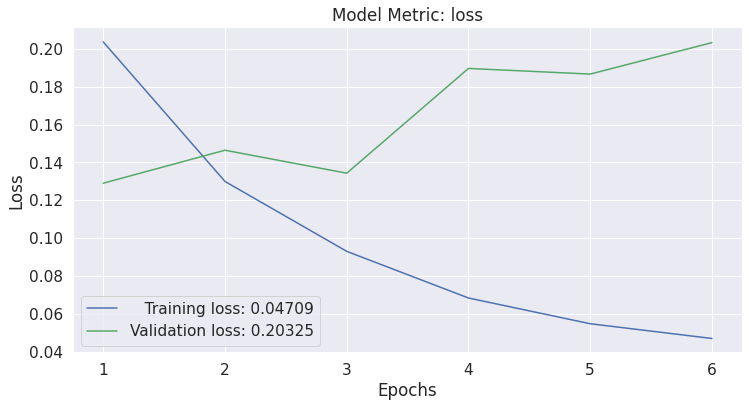

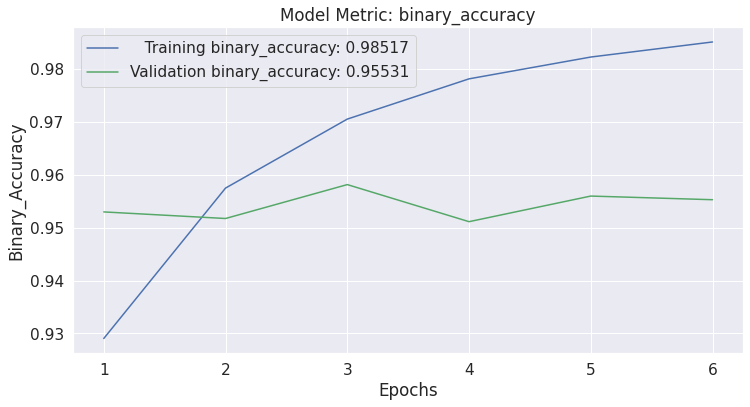

In [ ]:
plot_keras_history(history_under)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model_under.evaluate(
    X_val_enc_bow_down.todense(),    # features
    y_val,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

677/677 - 2s - loss: 0.2033 - binary_accuracy: 0.9553


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.2032543271780014

Test accuracy: 95.531 %


#### Model Prediction

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model_under.predict(X_test_enc_bow_down)
y_test_pred_probs

array([[0.9987465 ],
       [1.        ],
       [0.9943515 ],
       ...,
       [0.9970756 ],
       [0.9989351 ],
       [0.99919164]], dtype=float32)

In [ ]:
y_test_preds = tf.greater(y_test_pred_probs, .5)

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_preds)
conf_mat

array([[  860,   198],
       [  636, 17418]])

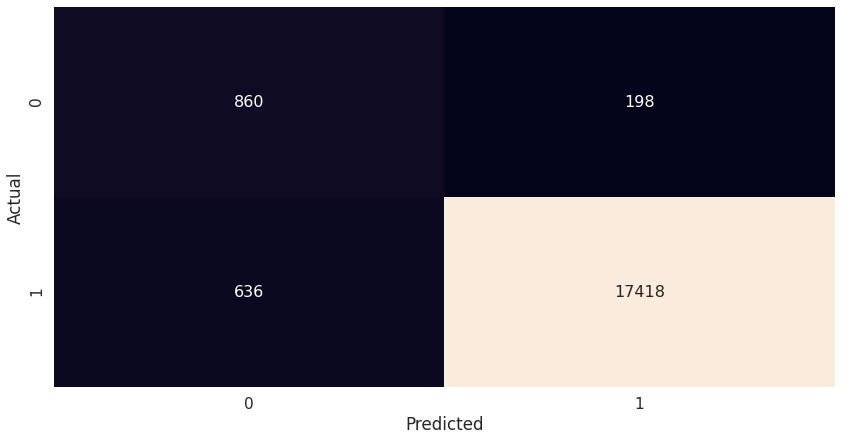

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_preds))

              precision    recall  f1-score   support

           0       0.57      0.81      0.67      1058
           1       0.99      0.96      0.98     18054

    accuracy                           0.96     19112
   macro avg       0.78      0.89      0.83     19112
weighted avg       0.97      0.96      0.96     19112



## LSTM model

Maybe we should not remove stopwords from LSTM to capture better the context.

### With Imbalanced dataset

In [ ]:
from collections import Counter
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
          count[word] += 1
    return count

In [ ]:
text = revs_preprocessed.review
counter = counter_word(text)
len(counter)

54129

In [ ]:
counter

Counter({'αρκετα': 2301,
         'καλος': 14319,
         'υπεροχος': 716,
         'γιατρος': 31458,
         'φοβερες': 20,
         'γνωσεις': 1827,
         'συνεπης': 3928,
         'επεξηγηματικος': 4285,
         'προθυμος': 1191,
         'χωρις': 4625,
         'κρυφες': 4,
         'χρεωσεις': 50,
         'επισκεψη': 3821,
         'συγκεκριμενο': 623,
         'ιατρο': 1043,
         'αποτελεσμα': 1026,
         'τυχαιας': 1,
         'επιλογης': 33,
         'δεν': 13315,
         'διεθετα': 1,
         'καμια': 878,
         'προηγουμενη': 141,
         'πληροφορια': 38,
         'ουτε': 710,
         'συσταση': 62,
         'διευκολυνε': 15,
         'εγγυτητα': 7,
         'ιατρειου': 516,
         'σχεση': 390,
         'χωρο': 460,
         'υπηρεσιακης': 1,
         'δραστηριοτητας': 6,
         'θετικη': 843,
         'εντυπωση': 1431,
         'προκαλεσαν': 7,
         'αφενος': 15,
         'μεν': 35,
         'συντομος': 22,
         'χρονος': 300,
         'μεσ

In [ ]:
num_words = len(counter)

max_length = 80

Maybe we can use a different vectorizer here

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:

#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
print(revs_preprocessed.review[0])
print(train_sequences[0])

καθησυχαστικη εμπειρη αποτελεσματικη
[52, 1305, 11092, 692, 954, 212, 4234, 295, 1147, 1181, 887, 760, 9, 2, 81, 3047, 202, 466, 757, 440, 27, 441, 3448, 384, 1951, 1398, 1276, 220, 1408, 606, 34, 484, 55, 1470, 123, 4834, 1555, 1050, 5, 8770, 197, 2073, 352, 99, 6467, 52, 11093, 45, 23, 57, 123, 378, 1, 564, 856, 5, 1142, 102, 3972, 223, 2522, 3973, 528, 158, 26, 623, 1291, 539, 126, 234, 8771, 327, 7396, 16116]


In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

lstm = Sequential()

lstm.add(Embedding(num_words, 32, input_length = max_length))
lstm.add(Bidirectional(LSTM(64, dropout=0.1, return_sequences=True)))
lstm.add(Bidirectional(LSTM(64, dropout=0.3)))
lstm.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
lstm.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,880,737
Trainable params: 1,880,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         

#### Fitting (training) our LSTM Model

In [ ]:
history_lstm = lstm.fit(
 train_padded,y_train,epochs=10, validation_data=(val_padded, y_val), callbacks=early_stop
)

Epoch 1/10
2708/2708 [==============================] - 511s 189ms/step - loss: 0.1181 - accuracy: 0.9591 - val_loss: 0.0943 - val_accuracy: 0.9654
Epoch 2/10
2708/2708 [==============================] - 511s 189ms/step - loss: 0.0776 - accuracy: 0.9731 - val_loss: 0.0952 - val_accuracy: 0.9653
Epoch 3/10
2708/2708 [==============================] - 515s 190ms/step - loss: 0.0627 - accuracy: 0.9795 - val_loss: 0.0974 - val_accuracy: 0.9676
Epoch 4/10
2708/2708 [==============================] - 513s 189ms/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.0991 - val_accuracy: 0.9671
Epoch 5/10
2708/2708 [==============================] - 504s 186ms/step - loss: 0.0432 - accuracy: 0.9868 - val_loss: 0.1077 - val_accuracy: 0.9667
Epoch 6/10
2708/2708 [==============================] - 499s 184ms/step - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.1184 - val_accuracy: 0.9655
Epoch 00006: early stopping


In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

#### Model Evaluation

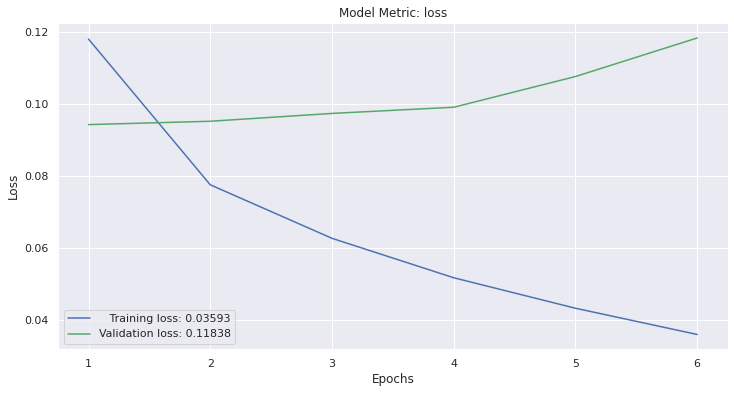

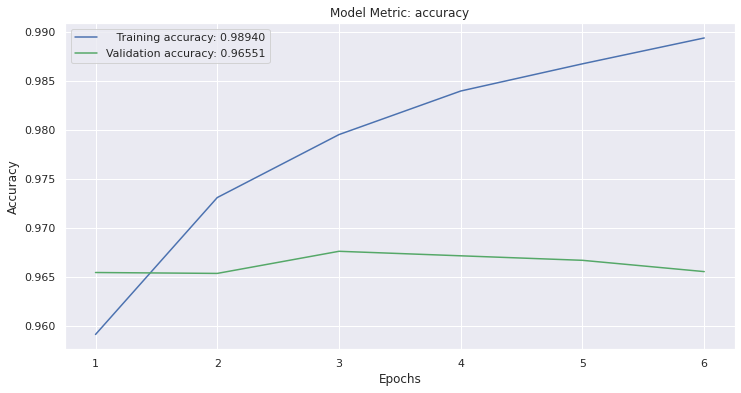

In [ ]:
sns.set()
plot_keras_history(history_lstm)

#### Model Prediction

In [ ]:
predicted = lstm.predict(test_padded) #change val and test
predicted = tf.greater(predicted, .5)

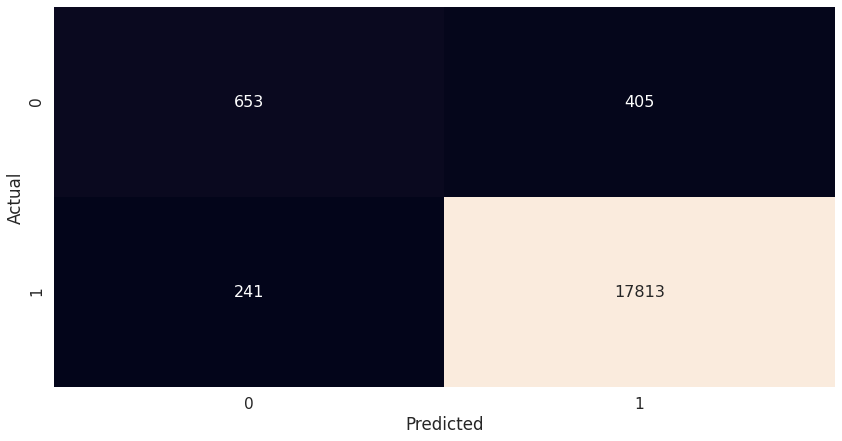

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Oversampling

In [ ]:
'''from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 100 # mean is 800
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
not_appr_upsampled = resample(not_approved,
                          replace=True, # sample with replacement
                          n_samples=len(approved)//4, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([approved, not_appr_upsampled])

# check new class counts
print(upsampled.approved.value_counts())
upsampled = upsampled.sample(frac=1)'''

'from sklearn.utils import resample\nfrom sklearn.model_selection import train_test_split\n\nnum_words = len(counter)\n\nmax_length = 100 # mean is 800\n#random_reviews = reviews.sample(frac=1)\n\n# concatenate our training data back together\nX = pd.concat([X_train, y_train], axis=1)\n\n# separate minority and majority classes\nnot_approved = X[X.approved==0]\napproved = X[X.approved==1]\n\n# upsample minority\nnot_appr_upsampled = resample(not_approved,\n                          replace=True, # sample with replacement\n                          n_samples=len(approved)//4, # match number in majority class\n                          random_state=27) # reproducible results\n\n# combine majority and upsampled minority\nupsampled = pd.concat([approved, not_appr_upsampled])\n\n# check new class counts\nprint(upsampled.approved.value_counts())\nupsampled = upsampled.sample(frac=1)'

In [ ]:
train_sentences = upsampled.review
train_labels = upsampled.approved
val_sentences = X_val
val_labels = y_val
test_sentences = X_test
test_labels = y_test

In [ ]:
upsampled.review

77999    κα τζουμα επροκειτο δωρεαν επισκεψη εκανε αρισ...
74613    πρωτη φορα επισκεφθηκα γυναικολογο κυρια δρακα...
26775    έκλεισα ραντεβου σαββατο εγινε επιβεβαιωση κυρ...
9788     ειχα ραντεβου 7 εφτασα ειχε 8 ατομα πριν εμενα...
94443    εξαιρετικος καθε αλλη φορα πλεον ορθοπεδικος ε...
                               ...                        
10487    ενδιαφερον ιατρου διερευνησει υπομονη προβλημα...
82005                                       όλα πηγαν καλα
94685                  γιατρος εξερετικος φυλικος προθημος
27842                                 ενεπευσε εμπιστοσυνη
78818    εμεινα πολυ ικανοποιημενη επισκεψη κυρια παναγ...
Name: review, Length: 102306, dtype: object

In [ ]:
X_train

13985     ειχα ζητησει συναρμολογηση 15 ημερες πριν αλλα...
25928     απολυτα καταρτισμενος φιλικος γνωστης αναλυτικ...
41869                    πολυ καλος επαγγελματιας ευγενικος
53268                            εμεινα πολυ ικανοποιημενος
15336     άψογη εξυπηρετησημηδενικο χρονος αναμονης συμβ...
                                ...                        
30200                           άψογος εξειδικευμενος σωστα
90133     πολυ καλος γιατρος ορεξη ακουσει εξετασει συμβ...
11206                                   ολα πηγαν πολυ καλα
99523                                  εξαιρετικη καθε φορα
107858                                ουσιαστικο ενδιαφερον
Name: review, Length: 86640, dtype: object

In [ ]:
val_labels.value_counts()

1    20461
0     1199
Name: approved, dtype: int64

In [ ]:
test_labels.value_counts()

1    18054
0     1058
Name: approved, dtype: int64

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
#word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(X_val)
test_sentences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sentences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

lstm_over = Sequential()

lstm_over.add(Embedding(num_words, 32, input_length = max_length))
#lstm_over.add(Bidirectional(LSTM(64, dropout=0.1, return_sequences=True)))
#lstm_over.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
lstm_over.add(Bidirectional(LSTM(64, dropout=0.3)))
lstm_over.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
lstm_over.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

lstm_over.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 1,781,921
Trainable params: 1,781,921
Non-trainable params: 0
_________________________________________________________________


#### Fitting (training) our LSTM Model

In [ ]:
history_lstm_over = lstm_over.fit(
 train_padded,train_labels,epochs=10, validation_data=(val_padded, y_val), callbacks=early_stop
)

Epoch 1/10
3198/3198 [==============================] - 273s 85ms/step - loss: 0.2191 - accuracy: 0.9189 - val_loss: 0.1227 - val_accuracy: 0.9566
Epoch 2/10
3198/3198 [==============================] - 275s 86ms/step - loss: 0.1224 - accuracy: 0.9606 - val_loss: 0.1187 - val_accuracy: 0.9579
Epoch 3/10
3198/3198 [==============================] - 275s 86ms/step - loss: 0.0933 - accuracy: 0.9709 - val_loss: 0.1085 - val_accuracy: 0.9652
Epoch 4/10
3198/3198 [==============================] - 277s 87ms/step - loss: 0.0770 - accuracy: 0.9768 - val_loss: 0.1113 - val_accuracy: 0.9633
Epoch 5/10
3198/3198 [==============================] - 277s 87ms/step - loss: 0.0672 - accuracy: 0.9803 - val_loss: 0.1248 - val_accuracy: 0.9625
Epoch 6/10
3198/3198 [==============================] - 274s 86ms/step - loss: 0.0600 - accuracy: 0.9822 - val_loss: 0.1273 - val_accuracy: 0.9616
Epoch 7/10
3198/3198 [==============================] - 275s 86ms/step - loss: 0.0546 - accuracy: 0.9840 - val_loss: 0

#### Model Evaluation

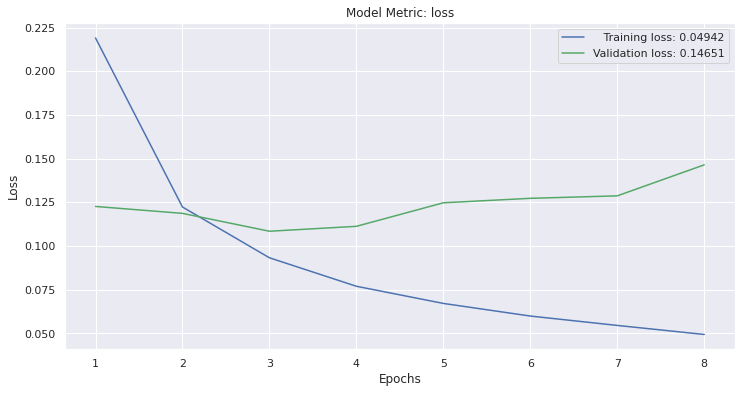

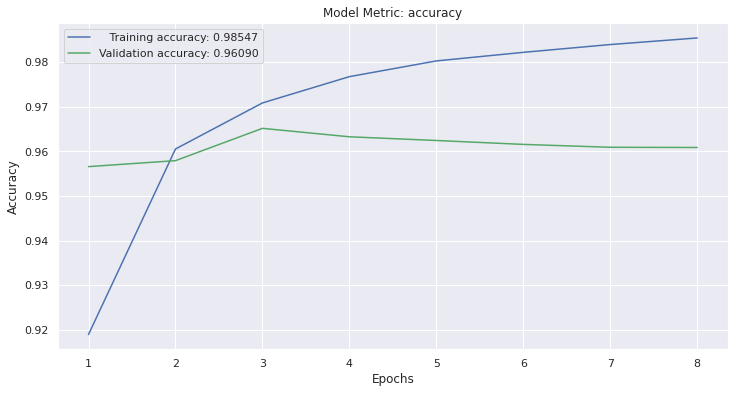

In [ ]:
sns.set()
plot_keras_history(history_lstm_over)

#### Model Prediction

In [ ]:
predicted_over = lstm_over.predict(test_padded) #change val and test
predicted_over = tf.greater(predicted_over, .5)

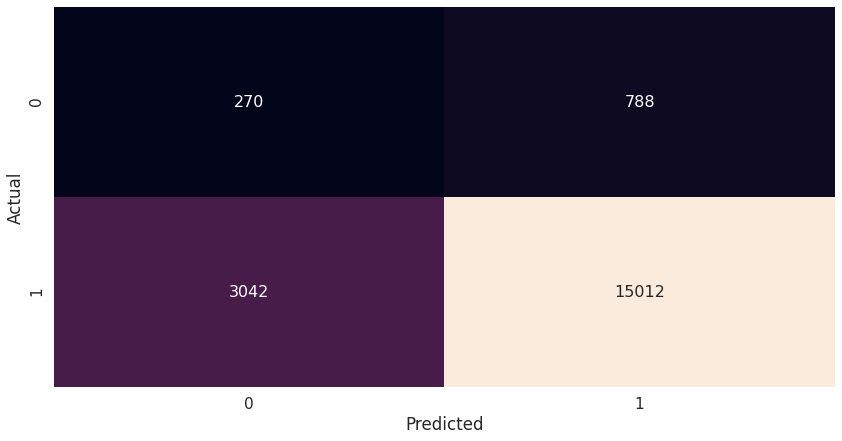

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_over)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Undersampling

In [ ]:
'''from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 60
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
appr_downsampled = resample(approved,
                          replace=True, # sample with replacement
                          n_samples=25000, # match number in majority class
                          random_state=27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_approved, appr_downsampled])

# check new class counts
print(downsampled.approved.value_counts())
downsampled = downsampled.sample(frac=1) #shuffle'''

'from sklearn.utils import resample\nfrom sklearn.model_selection import train_test_split\n\nnum_words = len(counter)\n\nmax_length = 60\n#random_reviews = reviews.sample(frac=1)\n\n# concatenate our training data back together\nX = pd.concat([X_train, y_train], axis=1)\n\n# separate minority and majority classes\nnot_approved = X[X.approved==0]\napproved = X[X.approved==1]\n\n# upsample minority\nappr_downsampled = resample(approved,\n                          replace=True, # sample with replacement\n                          n_samples=25000, # match number in majority class\n                          random_state=27) # reproducible results\n\n# combine minority and downsampled majority\ndownsampled = pd.concat([not_approved, appr_downsampled])\n\n# check new class counts\nprint(downsampled.approved.value_counts())\ndownsampled = downsampled.sample(frac=1) #shuffle'

In [ ]:
train_sentences = downsampled.review
train_labels = downsampled.approved
val_sentences = X_val
val_labels = y_val
test_sentences = X_test
test_labels = y_test

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
#word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(X_val)
test_sentences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sentences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

lstm_under = Sequential()

lstm_under.add(Embedding(num_words, 32, input_length = max_length))
lstm_under.add(Bidirectional(LSTM(64 ,dropout=0.1)))
lstm_under.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
lstm_under.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

lstm_under.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,781,921
Trainable params: 1,781,921
Non-trainable params: 0
_________________________________________________________________


#### Fitting (training) our LSTM Model

In [ ]:
history_lstm_under = lstm_under.fit(
 train_padded,train_labels,epochs=10, validation_data=(val_padded, val_labels), callbacks=early_stop
)

Epoch 1/10
932/932 [==============================] - 95s 102ms/step - loss: 0.2867 - accuracy: 0.8867 - val_loss: 0.1349 - val_accuracy: 0.9556
Epoch 2/10
932/932 [==============================] - 95s 102ms/step - loss: 0.1603 - accuracy: 0.9475 - val_loss: 0.1216 - val_accuracy: 0.9583
Epoch 3/10
932/932 [==============================] - 94s 101ms/step - loss: 0.1298 - accuracy: 0.9600 - val_loss: 0.1169 - val_accuracy: 0.9599
Epoch 4/10
932/932 [==============================] - 94s 101ms/step - loss: 0.1059 - accuracy: 0.9692 - val_loss: 0.1212 - val_accuracy: 0.9586
Epoch 5/10
932/932 [==============================] - 94s 101ms/step - loss: 0.0905 - accuracy: 0.9738 - val_loss: 0.1321 - val_accuracy: 0.9566
Epoch 6/10
932/932 [==============================] - 94s 101ms/step - loss: 0.0769 - accuracy: 0.9792 - val_loss: 0.1298 - val_accuracy: 0.9575
Epoch 7/10
932/932 [==============================] - 94s 101ms/step - loss: 0.0683 - accuracy: 0.9817 - val_loss: 0.1504 - val_ac

#### Model Evaluation

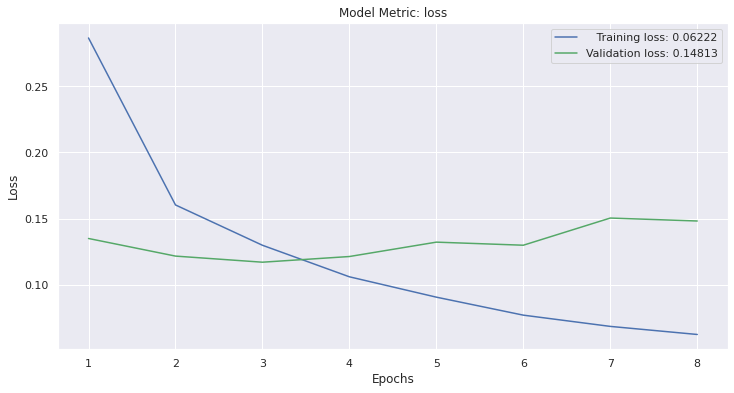

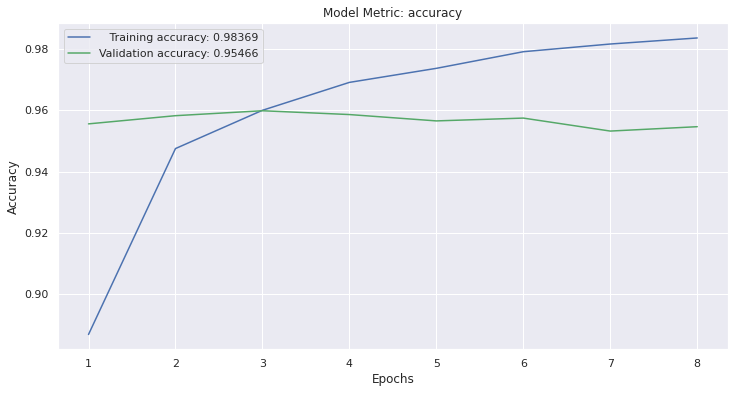

In [ ]:
sns.set()
plot_keras_history(history_lstm_under)

#### Model Prediction

In [ ]:
predicted_under = lstm_under.predict(test_padded) #change val and test
predicted_under = tf.greater(predicted_under, .5)

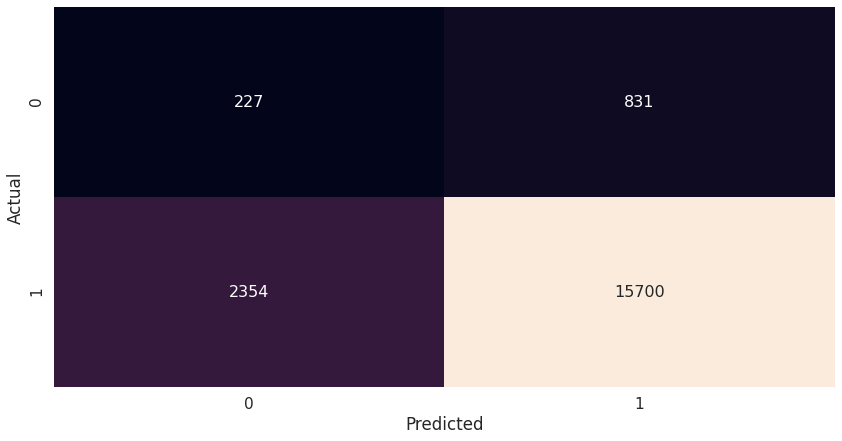

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_under)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

## Logistic Regression Model

### With Imbalanced dataset

In [ ]:
from sklearn.linear_model import LogisticRegression

def log_reg(X_train, y_train, X_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C, penalty='l2', max_iter=100000).fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Validation Score is', score)
    return model

#### Fitting (training) and Evaluating our LogReg Model

In [ ]:
log_model = log_reg(X_train_enc_bow, y_train, X_val_enc_bow, y_val)

Validation Score is 0.9633887349953832


#### Model Prediction

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = log_model.predict(X_test_enc_bow)
predicted = np.where(predicted > 0.5, 1, 0)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression AUC:",metrics.roc_auc_score(y_test, predicted))

Logistic Regression Accuracy: 0.962222687316869
Logistic Regression Precision: 0.9708758965442296
Logistic Regression Recall: 0.9896975739448322
Logistic Regression AUC: 0.7415406584279927


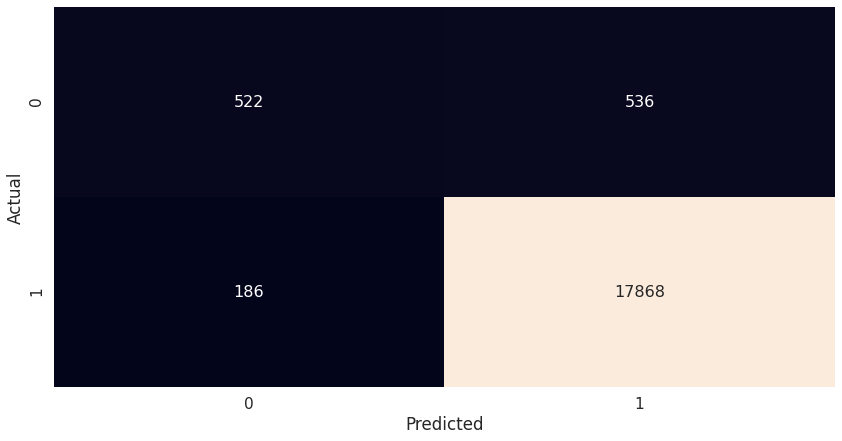

In [ ]:
array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Oversampling

#### Fitting (training) and Evaluating our LogReg Model

In [ ]:
log_model_up = log_reg(X_train_enc_bow_up, upsampled.approved, X_val_enc_bow_up, y_val)

Validation Score is 0.9581255771006464


In [ ]:
upsampled.review

50693     λογω σχολιων διαβαστηκαν πηγα μεγαλες προσδοκι...
37054     ευγενικος εξυπηρετικος γιατρος ασχοληθηκε πραγ...
50592                       άψογος ευγενικος χαλαρος ικανος
47129     γιατρος πολυ εξυπηρετικος τυπικοσεμεινα πολυ ε...
38663                                   όλα πηγαν πολυ καλα
                                ...                        
96445     εξαιρετικος γιατρος καταρτισμενος ευγενικος πα...
101176    ενταξει ωρα ραντεβου αλλα δεν πολυ ασχοληθεικε...
39868     γραμματεια δεν ενημερωνεται ραντεβου γινονται ...
16979     καθαρισμος εγινε πολυ γρηγορα αναρχα επομενως ...
25391     ειμαι πολυ ευχαριστημενη αποτελεσματα αγωγης α...
Name: review, Length: 102306, dtype: object

#### Model Prediction

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = log_model_up.predict(X_test_enc_bow_up)
predicted = np.where(predicted > 0.5, 1, 0)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression AUC:",metrics.roc_auc_score(y_test, predicted))

Logistic Regression Accuracy: 0.9569380493930515
Logistic Regression Precision: 0.9844795591295057
Logistic Regression Recall: 0.9697020050958236
Logistic Regression AUC: 0.8544162199392161


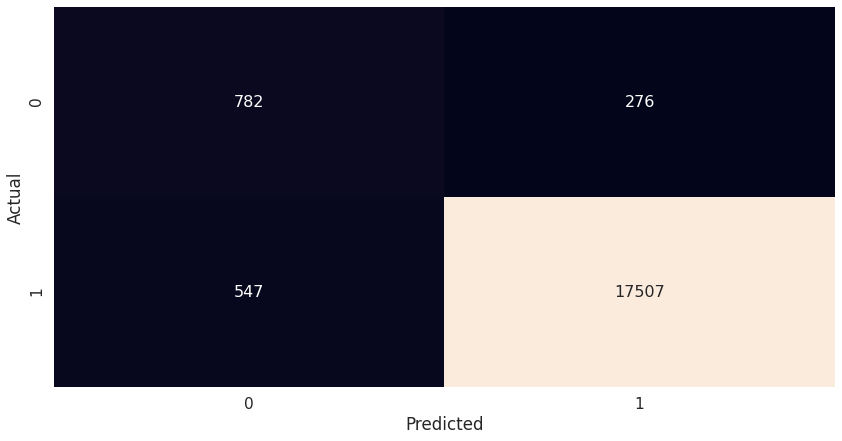

In [ ]:
array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Undersampling

#### Fitting (training) our LogReg Model

In [ ]:
log_model_down = log_reg(X_train_enc_bow_down, downsampled.approved, X_val_enc_bow_down, y_val)

Validation Score is 0.9575715604801477


#### Model Prediction

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = log_model_down.predict(X_test_enc_bow_down)
predicted = np.where(predicted > 0.5, 1, 0)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression AUC:",metrics.roc_auc_score(y_test, predicted))

Logistic Regression Accuracy: 0.9565194642109669
Logistic Regression Precision: 0.9811162634784066
Logistic Regression Recall: 0.972693032015066
Logistic Regression AUC: 0.8266111662910869


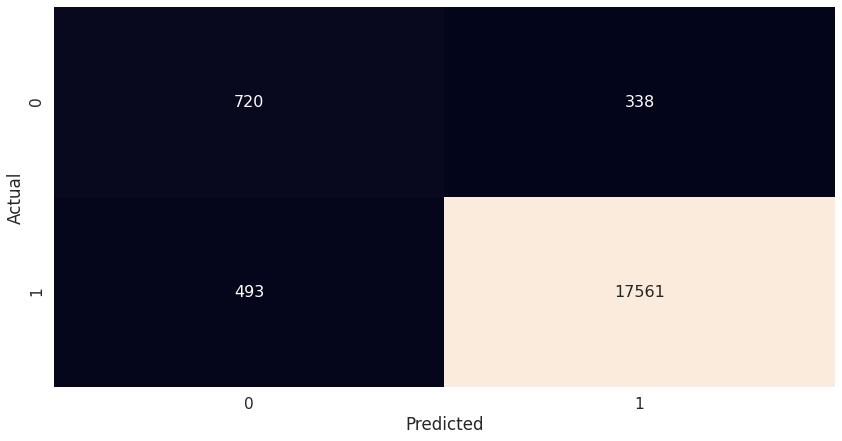

In [ ]:
array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

## Saving the models

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward')
model_over.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_over')
model_under.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_under')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_over/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_under/assets


In [ ]:
lstm.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm')
lstm_over.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_over')
lstm_under.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_under')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_over/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_under/assets


## Logistic Regression Word Highlighting

In [ ]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(counter_vectorizer, log_model)

In [ ]:
X_test

30817     εξαιρετικος πανταασχοληθηκε τομ γιο μουηταν ηρ...
15456                       ευγενικος προσιτος χαρα συστηνω
117805    ξαιρετικης καταρτισης γιατροςευγενηςαμεσος κυρ...
92691              πολυ φιλικος προσιτος αναλυτικος εξεταση
107854                πολυ ευγενικη εκανε νιωσω εμπιστοσυνη
                                ...                        
110392      αφιερωσε απαιτουμενο χρονο πολυ σαφης οσα ελεγε
93144     προσηνης ευγενικος διακριτικος κος ζησης έδωσε...
26426                                        πολυ καλος ολα
121935             όλα καλα εξαιρεσει κανεις χρονο αναμονης
28782                                                τελιος
Name: review, Length: 19112, dtype: object

In [ ]:
print(X_test.iloc[10])

πολυ καλος ανθρωπος πανω απ’ ολα ειλικρινηςμε εξετασε λεπτομερως υπομονη αρκετη ωρα μεχρι φτασει τελικο συμπερασμα


In [ ]:
print(pipe.predict_proba([X_test.iloc[10]]))

[[0.01216551 0.98783449]]


In [ ]:
pipe.predict_proba([X_test.iloc[10]])

array([[0.01216551, 0.98783449]])

In [ ]:
pipe.predict_proba

<function sklearn.pipeline.Pipeline.predict_proba>

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["not approved", "approved"], bow=False)

In [ ]:
X_test

30817     εξαιρετικος πανταασχοληθηκε τομ γιο μουηταν ηρ...
15456                       ευγενικος προσιτος χαρα συστηνω
117805    ξαιρετικης καταρτισης γιατροςευγενηςαμεσος κυρ...
92691              πολυ φιλικος προσιτος αναλυτικος εξεταση
107854                πολυ ευγενικη εκανε νιωσω εμπιστοσυνη
                                ...                        
110392      αφιερωσε απαιτουμενο χρονο πολυ σαφης οσα ελεγε
93144     προσηνης ευγενικος διακριτικος κος ζησης έδωσε...
26426                                        πολυ καλος ολα
121935             όλα καλα εξαιρεσει κανεις χρονο αναμονης
28782                                                τελιος
Name: review, Length: 19112, dtype: object

In [ ]:
max_features = X_test.str.split().map(lambda x: len(x)).max()
print(max_features)

624


In [ ]:
import random
#random.seed(13)
idx = random.randint(0, len(X_test))

exp = explainer.explain_instance(X_test.iloc[idx] #normalize("τελειος γιατρος. εξαιρετικη διαγνωση")
    , pipe.predict_proba, num_features=5
)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [ ]:
X_test.iloc[idx] 

'χαμογελαστος κερδιζει αξια εμπιστοσυνη ασθενει βοηθα νιωθει ανετα ασθενης συζητησιμος επεξηγηματικος ασχολειθηκε εις βαθος περιπτωση'

In [ ]:
print(
    f"Probability of the sample to be not approved is: {pipe.predict_proba([X_test.iloc[idx]])[0, 1]}\n"
)
print(f"Explanation as a list of weighted features:")
exp.as_list()

Probability of the sample to be not approved is: 0.9650464577390232

Explanation as a list of weighted features:


[('εις', 0.15446062844259079),
 ('νιωθει', 0.06038467119977053),
 ('βαθος', -0.05720644673436647),
 ('ανετα', 0.04868033954601364),
 ('αξια', 0.03742232757636006)]

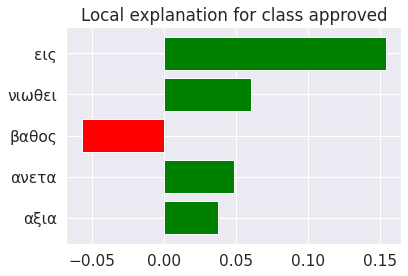

In [ ]:
f = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)